In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy import stats
from collections import OrderedDict
import warnings
#import shap
warnings.filterwarnings('ignore')
import time

In [2]:
#import gpboost as gpb
#import lightgbm as lgb
from linearmodels.datasets import wage_panel
from linearmodels.panel import compare
from linearmodels.panel import RandomEffects
from linearmodels.panel import BetweenOLS
from linearmodels.panel import FirstDifferenceOLS
from linearmodels import PanelOLS
from linearmodels import PooledOLS

In [3]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.datasets import grunfeld
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import RandomForestRegressor
from merf import MERF
from merf.viz import plot_merf_training_stats

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as image
import graphviz
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20,15]
plt.rcParams['figure.dpi'] = 150

In [ ]:
def f1d(x):
    """Non-linear function for simulation"""
    return (1.7 * (1 / (1 + np.exp(-(x - 0.5) * 20)) + 0.75 * x))
print("It is recommended that the examples are run in interactive mode")

In [5]:
data = grunfeld.load_pandas().data

In [6]:
data = wage_panel.load()

In [7]:
data

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,8,0,2080,1,9,0,1.591879,64,5
4356,12548,1984,0,9,0,2080,1,9,1,1.212543,81,5
4357,12548,1985,0,10,0,2080,1,9,0,1.765962,100,5
4358,12548,1986,0,11,0,2080,1,9,1,1.745894,121,5


In [8]:
data['weeks'] = data['hours']/(24*7)

In [9]:
data = data.drop(columns = 'hours')

In [10]:
data['index'] = data.index

In [12]:
data = data.set_index(['nr','year'])

In [13]:
data

black  exper  hisp  married  educ  union     lwage  expersq  \
nr    year                                                                
13    1980      0      1     0        0    14      0  1.197540        1   
      1981      0      2     0        0    14      1  1.853060        4   
      1982      0      3     0        0    14      0  1.344462        9   
      1983      0      4     0        0    14      0  1.433213       16   
      1984      0      5     0        0    14      0  1.568125       25   
...           ...    ...   ...      ...   ...    ...       ...      ...   
12548 1983      0      8     0        1     9      0  1.591879       64   
      1984      0      9     0        1     9      1  1.212543       81   
      1985      0     10     0        1     9      0  1.765962      100   
      1986      0     11     0        1     9      1  1.745894      121   
      1987      0     12     0        1     9      1  1.466543      144   

            occupation      weeks  index  
nr    year                                
13    1980           9  15.904762      0  
      1981           9  13.809524      1  
      1982           9  17.500000      2  
      1983           9  17.619048      3  
      1984           5  18.279762      4  
...                ...        ...    ...  
12548 1983           5  12.380952   4355  
      1984           5  12.380952   4356  
      1985           5  12.380952   4357  
      1986           5  12.380952   4358  
      1987           5  20.119048   4359  

[4360 rows x 11 columns]

In [109]:
idx = pd.MultiIndex.from_product([[],[]], names=['nr', 'year'])
col = ['black', 'exper', 'hisp', 'married', 'educ', 'union', 'lwage', 'expersq', 'occupation', 'weeks', 'index']

df_train = pd.DataFrame('-', idx, col)
df_test = pd.DataFrame('-', idx, col)

In [110]:
for i in data.index.get_level_values('nr').unique():
    df_train = df_train.append(data[data.index.get_level_values('nr') == i][:6])
    df_test = df_test.append(data[data.index.get_level_values('nr') == i][6:])   

In [111]:
df_test = df_test.reset_index()
df_train = df_train.reset_index()
data = data.reset_index()

In [112]:
df_test = df_test.astype({"black": 'float64', "exper": 'float64', "hisp": 'float64', "married": 'float64', 
                          "educ": 'float64', "union": 'float64', "lwage": 'float64', "expersq": 'float64', 
                          "occupation": 'float64', "weeks": 'float64', "nr": 'float64'}, errors = 'raise')
df_train = df_train.astype({"black": 'float64', "exper": 'float64', "hisp": 'float64', "married": 'float64', 
                          "educ": 'float64', "union": 'float64', "lwage": 'float64', "expersq": 'float64', 
                          "occupation": 'float64', "weeks": 'float64', "nr": 'float64'}, errors = 'raise')

In [113]:
X_test = df_test[['black', 'exper', 'hisp', 'educ', 'union', 'expersq', 'weeks']]
X_train = df_train[['black', 'exper', 'hisp', 'educ', 'union', 'expersq', 'weeks']]
y_train = df_train['lwage']
y_test = df_test['lwage']

In [114]:
X_test_ix= df_test[['black', 'exper', 'hisp', 'educ', 'union', 'expersq', 'weeks', 'index']]
X_train_ix = df_train[['black', 'exper', 'hisp', 'educ', 'union', 'expersq', 'weeks', 'index']]
y_train_ix = df_train[['lwage', 'index']]
y_test_ix = df_test[['lwage', 'index']]

In [115]:
data_train = gpb.Dataset(data  = X_train, 
                         label = y_train)
data_test = gpb.Dataset(data = X_test, 
                         label = y_test,  reference=data_train)
data_total = gpb.Dataset(data = data[['black', 'exper', 'hisp', 'educ', 'union', 'expersq', 'weeks']], 
                        label = data['lwage'])

In [116]:
#gp_model = gpb.GPModel(group_data = df_train.nr)
gp_model = gpb.GPModel(group_data = df_train[['nr', 'year']])

In [24]:
# params https://github.com/fabsig/GPBoost/blob/master/docs/Parameters.rst#metric-parameters

In [25]:
params = {'objective': 'regression_l2',  'verbose':0, 'leaves_newton_update': True }

In [26]:
param_grid_large = {'learning_rate': np.arange(.01,.1,0.01), 'min_data_in_leaf': [5,10,20,50,100,200],
                    'max_depth': np.arange(1,20,1), 'max_bin': [50, 100,150, 200, 255,400, 500,700, 1000]}
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_large,
                                             params=params,
                                             num_try_random=100,
                                             gp_model = gp_model,
                                             nfold=4,
                                             use_gp_model_for_validation=True,
                                             train_set= data_train,
                                             verbose_eval=1,
                                             num_boost_round=5000, 
                                             early_stopping_rounds=20,
                                             seed=42,
                                             metrics='rmse')

Starting random grid search with 100 trials out of 9234 parameter combinations...
Trying parameter combination 1 of 100: {'learning_rate': 0.05, 'min_data_in_leaf': 10, 'max_depth': 12, 'max_bin': 200} ...
***** New best score (0.3857582973814728) found for the following parameter combination:
{'learning_rate': 0.05, 'min_data_in_leaf': 10, 'max_depth': 12, 'max_bin': 200, 'num_boost_round': 293}
Trying parameter combination 2 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 100, 'max_depth': 18, 'max_bin': 150} ...
***** New best score (0.3846666899813035) found for the following parameter combination:
{'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 100, 'max_depth': 18, 'max_bin': 150, 'num_boost_round': 323}
Trying parameter combination 3 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 20, 'max_depth': 4, 'max_bin': 1000} ...
***** New best score (0.3842317224514301) found for the following parameter combination:
{'learning_rate': 0

Trying parameter combination 56 of 100: {'learning_rate': 0.03, 'min_data_in_leaf': 100, 'max_depth': 11, 'max_bin': 200} ...
Trying parameter combination 57 of 100: {'learning_rate': 0.08, 'min_data_in_leaf': 50, 'max_depth': 9, 'max_bin': 200} ...
Trying parameter combination 58 of 100: {'learning_rate': 0.08, 'min_data_in_leaf': 50, 'max_depth': 6, 'max_bin': 100} ...
Trying parameter combination 59 of 100: {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'max_depth': 4, 'max_bin': 700} ...
Trying parameter combination 60 of 100: {'learning_rate': 0.04, 'min_data_in_leaf': 10, 'max_depth': 10, 'max_bin': 400} ...
Trying parameter combination 61 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 50, 'max_depth': 5, 'max_bin': 50} ...
Trying parameter combination 62 of 100: {'learning_rate': 0.09, 'min_data_in_leaf': 200, 'max_depth': 1, 'max_bin': 500} ...
Trying parameter combination 63 of 100: {'learning_rate': 0.04, 'min_data_in_leaf': 100, 'max_depth': 7, 'max_bi

In [27]:
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

Best number of iterations: 1639
Best score: 0.3816770174272448
Best parameters: {'learning_rate': 0.05, 'min_data_in_leaf': 20, 'max_depth': 2, 'max_bin': 50}


In [28]:
params = {'objective': 'regression_l2', 'learning_rate': 0.05, 'min_data_in_leaf': 20, 'max_depth': 2, 'max_bin': 50,'verbose':0}

In [29]:
bst = gpb.cv(params = params, train_set = data_train ,use_gp_model_for_validation = True, gp_model = gp_model,
                num_boost_round = 6000, early_stopping_rounds = 50, nfold = 10, verbose_eval = True, show_stdv =False, seed = 42)

[1]	cv_agg's l2: 0.149725
[2]	cv_agg's l2: 0.148148
[3]	cv_agg's l2: 0.147125
[4]	cv_agg's l2: 0.146531
[5]	cv_agg's l2: 0.145977
[6]	cv_agg's l2: 0.145614
[7]	cv_agg's l2: 0.145108
[8]	cv_agg's l2: 0.144617
[9]	cv_agg's l2: 0.144064
[10]	cv_agg's l2: 0.14396
[11]	cv_agg's l2: 0.143785
[12]	cv_agg's l2: 0.143375
[13]	cv_agg's l2: 0.143295
[14]	cv_agg's l2: 0.143157
[15]	cv_agg's l2: 0.143026
[16]	cv_agg's l2: 0.142874
[17]	cv_agg's l2: 0.142767
[18]	cv_agg's l2: 0.142641
[19]	cv_agg's l2: 0.142377
[20]	cv_agg's l2: 0.142202
[21]	cv_agg's l2: 0.142316
[22]	cv_agg's l2: 0.142269
[23]	cv_agg's l2: 0.142096
[24]	cv_agg's l2: 0.142196
[25]	cv_agg's l2: 0.142173
[26]	cv_agg's l2: 0.142033
[27]	cv_agg's l2: 0.141946
[28]	cv_agg's l2: 0.141905
[29]	cv_agg's l2: 0.14189
[30]	cv_agg's l2: 0.141909
[31]	cv_agg's l2: 0.141944
[32]	cv_agg's l2: 0.141784
[33]	cv_agg's l2: 0.141657
[34]	cv_agg's l2: 0.141672
[35]	cv_agg's l2: 0.141726
[36]	cv_agg's l2: 0.141812
[37]	cv_agg's l2: 0.141803
[38]	cv_agg'

In [30]:
print("Iter " + str(np.argmin(bst['l2-mean'])))

Iter 65


In [31]:
data_train = gpb.Dataset(X_train, y_train)
data_eval = gpb.Dataset(X_test, y_test, reference=data_train)
gp_model = gpb.GPModel(group_data = df_train[['nr', 'year']], cov_function="exponential")
gp_model.set_prediction_data(group_data_pred = df_test[['nr', 'year']])
# Include random effect predictions for validation (=default)

In [32]:
evals_result = {} 

In [33]:
bst = gpb.train(params=params, train_set=data_train, gp_model = gp_model, valid_sets = data_test, num_boost_round=65, evals_result = evals_result,
               use_gp_model_for_validation=True)
gp_model.summary()
# include random effect use_gp_model_for_validation=True
# dont include re for validation use_gp_model_for_validation=False

[1]	valid_0's l2: 0.200594
[2]	valid_0's l2: 0.199874
[3]	valid_0's l2: 0.199386
[4]	valid_0's l2: 0.198682
[5]	valid_0's l2: 0.199451
[6]	valid_0's l2: 0.195698
[7]	valid_0's l2: 0.195541
[8]	valid_0's l2: 0.193695
[9]	valid_0's l2: 0.19108
[10]	valid_0's l2: 0.189732
[11]	valid_0's l2: 0.194512
[12]	valid_0's l2: 0.193161
[13]	valid_0's l2: 0.193302
[14]	valid_0's l2: 0.192522
[15]	valid_0's l2: 0.19113
[16]	valid_0's l2: 0.190131
[17]	valid_0's l2: 0.190062
[18]	valid_0's l2: 0.190369
[19]	valid_0's l2: 0.189341
[20]	valid_0's l2: 0.188718
[21]	valid_0's l2: 0.18692
[22]	valid_0's l2: 0.186772
[23]	valid_0's l2: 0.185802
[24]	valid_0's l2: 0.187105
[25]	valid_0's l2: 0.187979
[26]	valid_0's l2: 0.187187
[27]	valid_0's l2: 0.186065
[28]	valid_0's l2: 0.185987
[29]	valid_0's l2: 0.186323
[30]	valid_0's l2: 0.186608
[31]	valid_0's l2: 0.185651
[32]	valid_0's l2: 0.184799
[33]	valid_0's l2: 0.185076
[34]	valid_0's l2: 0.184575
[35]	valid_0's l2: 0.184698
[36]	valid_0's l2: 0.183801
[37]

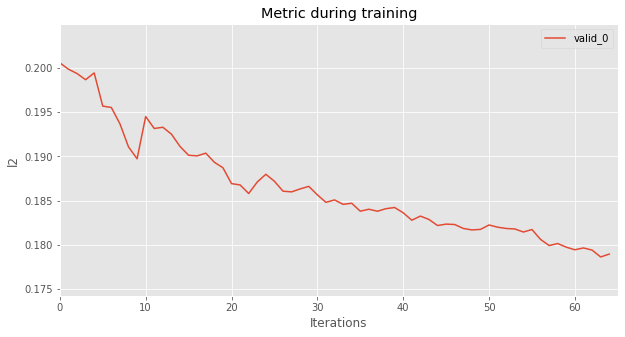

In [34]:
gpb.plot_metric(evals_result, metric='l2', figsize=(10, 5))
plt.show()

In [35]:
pred = bst.predict(data=X_test, group_data_pred = df_test[['nr', 'year']] )
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] 
np.sqrt(np.mean((y_test - y_pred) ** 2)) 

0.42301991697282193

In [36]:
print(pred['fixed_effect'])
print(pred['random_effect_mean'] )
print(pred['random_effect_cov'] )

[1.65273968 1.75237032 1.63399191 ... 1.62578369 1.591023   1.18131735]
[-0.02697199 -0.02697199 -0.06281747 ...  0.50747592 -0.17577968
 -0.17577968]
None


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

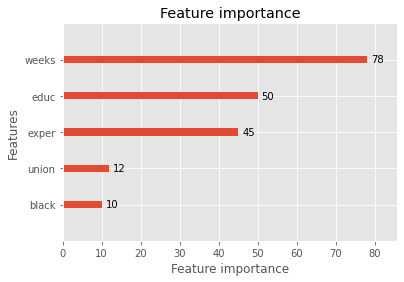

In [37]:
gpb.plot_importance(bst)

In [38]:
#gpb.plot_tree(bst) - пока не работает
#gpb.create_tree_digraph(bst) - same

<AxesSubplot:title={'center':'Split value histogram for feature with name exper'}, xlabel='Feature split value', ylabel='Count'>

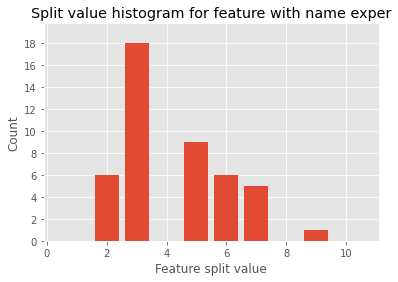

In [39]:
gpb.plot_split_value_histogram(bst, feature = 'exper')

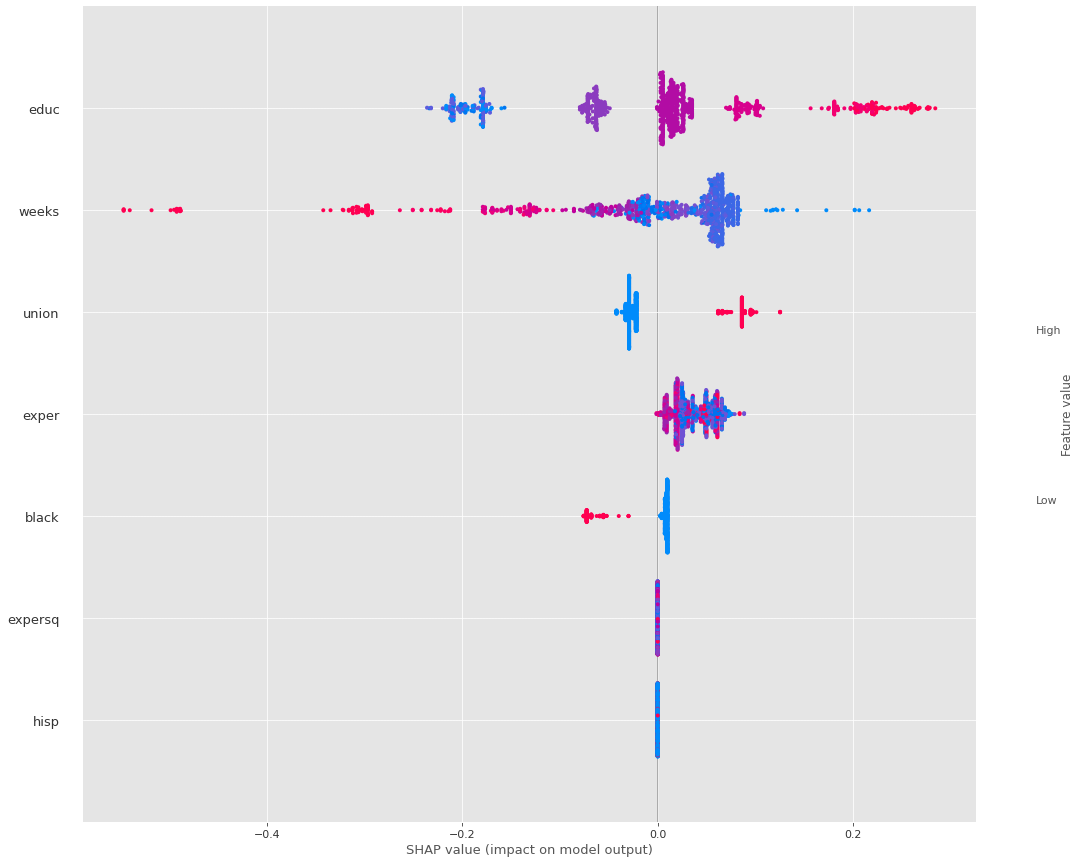

In [40]:
shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,15))

In [41]:
results = pd.DataFrame(columns = ["RMSE","Time"],
                       index = ["GPBoost", "Linear_ME","Boosting_Ign","Boosting_Cat","MERF"])

gp_model = gpb.GPModel(group_data =  df_train[['nr', 'year']])
start_time = time.time() 
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round= 65)
results.loc["GPBoost","Time"] = time.time() - start_time
pred = bst.predict(data=X_test, group_data_pred = df_test[['nr','year']])
y_pred = pred['fixed_effect'] + pred['random_effect_mean']
results.loc["GPBoost","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))


In [42]:
# 2. Linear mixed effects model 
gp_model = gpb.GPModel(group_data = df_train[['nr', 'year']])
X_train_linear = np.column_stack((np.ones(len(df_train)),X_train))
X_test_linear = np.column_stack((np.ones(len(df_test)),X_test))
start_time = time.time() 
gp_model.fit(y=df_train['lwage'], X=X_train_linear) 
results.loc["Linear_ME","Time"] = time.time() - start_time
y_pred = gp_model.predict(group_data_pred=df_test[['nr', 'year']], X_pred=X_test_linear)
F_pred = X_test_linear.dot(gp_model.get_coef())
results.loc["Linear_ME","RMSE"] = np.sqrt(np.mean((y_test - y_pred['mu']) ** 2))

In [43]:
# 3. Gradient tree-boosting ignoring the grouping variable ('Boosting_Ign')
cvbst = gpb.cv(params=params, train_set=data_train,
               num_boost_round=6000, early_stopping_rounds=20,
               nfold=10, verbose_eval=True, show_stdv=False, seed=42)
best_iter = np.argmin(cvbst['l2-mean']);
print("Best number of iterations: " + str(best_iter))

[1]	cv_agg's l2: 0.280233
[2]	cv_agg's l2: 0.278123
[3]	cv_agg's l2: 0.276302
[4]	cv_agg's l2: 0.274458
[5]	cv_agg's l2: 0.272883
[6]	cv_agg's l2: 0.271386
[7]	cv_agg's l2: 0.270014
[8]	cv_agg's l2: 0.268647
[9]	cv_agg's l2: 0.267414
[10]	cv_agg's l2: 0.266229
[11]	cv_agg's l2: 0.265028
[12]	cv_agg's l2: 0.263778
[13]	cv_agg's l2: 0.262497
[14]	cv_agg's l2: 0.261226
[15]	cv_agg's l2: 0.259944
[16]	cv_agg's l2: 0.258569
[17]	cv_agg's l2: 0.257272
[18]	cv_agg's l2: 0.256285
[19]	cv_agg's l2: 0.255116
[20]	cv_agg's l2: 0.25395
[21]	cv_agg's l2: 0.252888
[22]	cv_agg's l2: 0.252072
[23]	cv_agg's l2: 0.251231
[24]	cv_agg's l2: 0.250196
[25]	cv_agg's l2: 0.249326
[26]	cv_agg's l2: 0.248588
[27]	cv_agg's l2: 0.247962
[28]	cv_agg's l2: 0.24734
[29]	cv_agg's l2: 0.246622
[30]	cv_agg's l2: 0.245957
[31]	cv_agg's l2: 0.245372
[32]	cv_agg's l2: 0.24482
[33]	cv_agg's l2: 0.244257
[34]	cv_agg's l2: 0.243746
[35]	cv_agg's l2: 0.243146
[36]	cv_agg's l2: 0.24263
[37]	cv_agg's l2: 0.242199
[38]	cv_agg's 

In [44]:
start_time = time.time() # measure time
bst = gpb.train(params=params, train_set=data_train, num_boost_round= 250)
results.loc["Boosting_Ign","Time"] = time.time() - start_time
y_pred = bst.predict(data=X_test)
results.loc["Boosting_Ign","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

In [45]:
rf_params={'max_depth': 6, 'n_estimators': 300}
merf_model = MERF(max_iterations=15, fixed_effects_model = RandomForestRegressor(n_estimators= 2000, max_depth = 15,  n_jobs= -1),
        gll_early_stop_threshold=None)
print("Warning: the following takes a lot of time")
start_time = time.time()
merf_model.fit(pd.DataFrame(X_train), np.ones(shape=(len(df_train),1)), df_train['nr'], df_train['lwage'])

INFO     [merf.py:307] Training GLL is -5809.089918563496 at iteration 1.
INFO     [merf.py:307] Training GLL is -8605.556335915533 at iteration 2.
INFO     [merf.py:307] Training GLL is -9065.108226776556 at iteration 3.
INFO     [merf.py:307] Training GLL is -9127.318578460045 at iteration 4.
INFO     [merf.py:307] Training GLL is -9116.419568304977 at iteration 5.
INFO     [merf.py:307] Training GLL is -9099.286628898031 at iteration 6.
INFO     [merf.py:307] Training GLL is -9110.514315819424 at iteration 7.
INFO     [merf.py:307] Training GLL is -9084.733692771106 at iteration 8.
INFO     [merf.py:307] Training GLL is -9083.375373587813 at iteration 9.
INFO     [merf.py:307] Training GLL is -9073.403448160534 at iteration 10.
INFO     [merf.py:307] Training GLL is -9062.36491594772 at iteration 11.
INFO     [merf.py:307] Training GLL is -9049.527001463513 at iteration 12.
INFO     [merf.py:307] Training GLL is -9052.429627837959 at iteration 13.
INFO     [merf.py:307] Training GLL

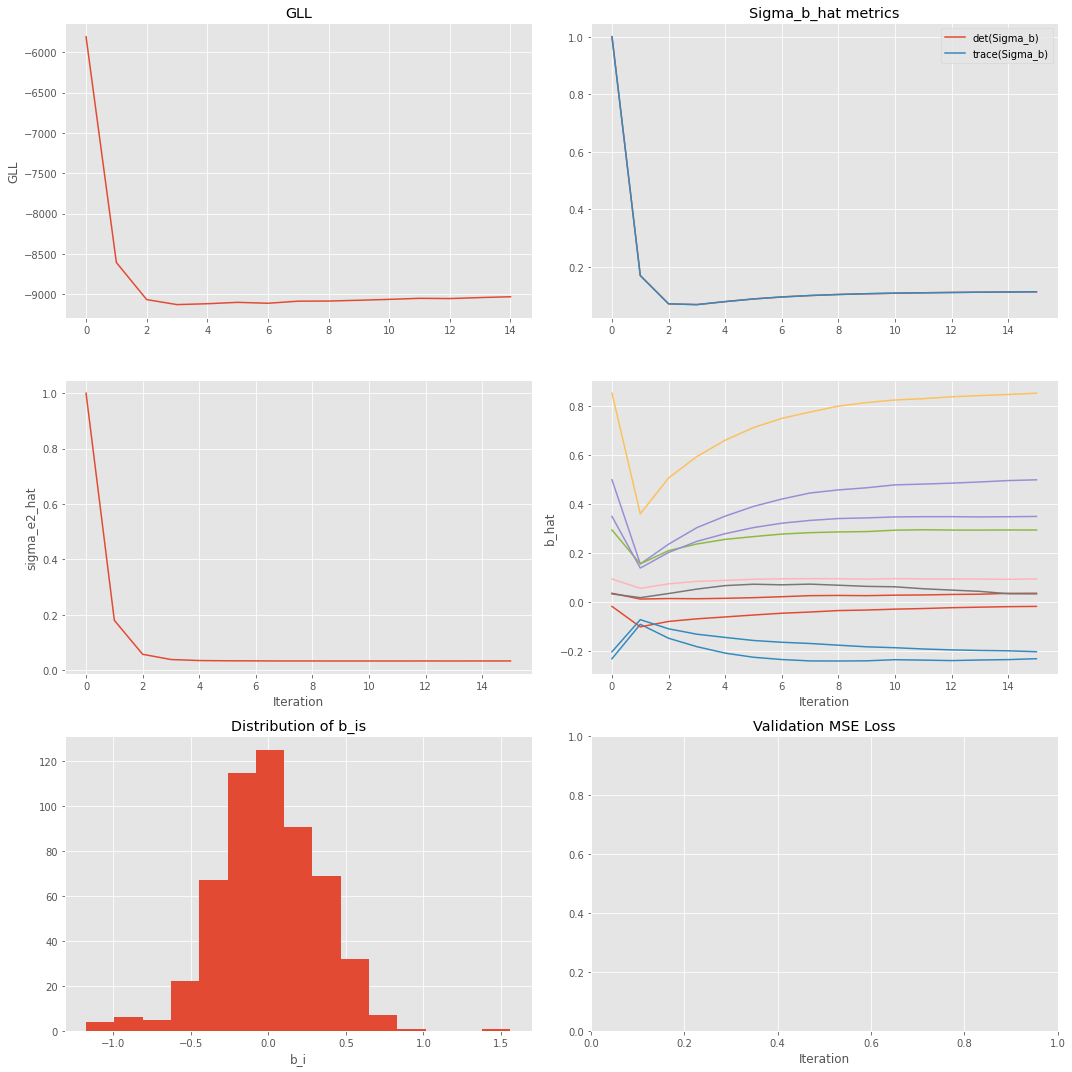

In [46]:
plot_merf_training_stats(merf_model, num_clusters_to_plot=10)

In [47]:
merf_model.trained_fe_model

RandomForestRegressor(max_depth=15, n_estimators=2000, n_jobs=-1)

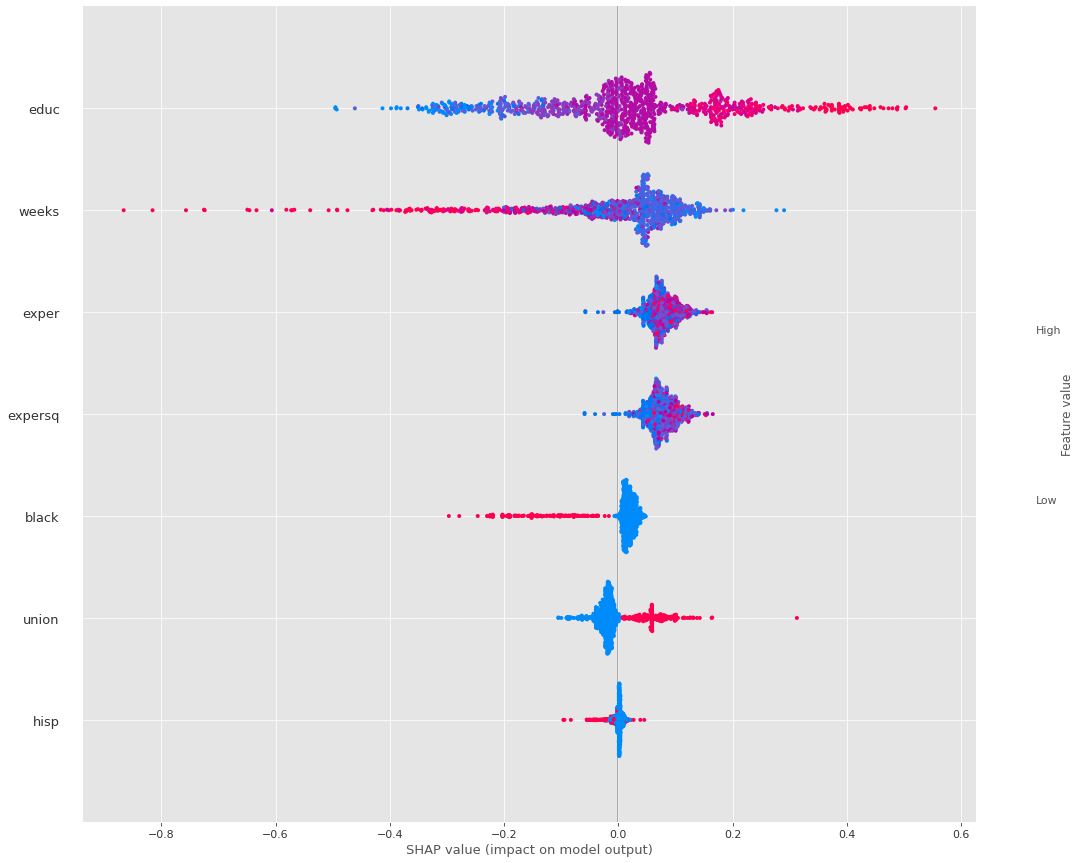

In [48]:
explainer = shap.TreeExplainer(merf_model.trained_fe_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,15))

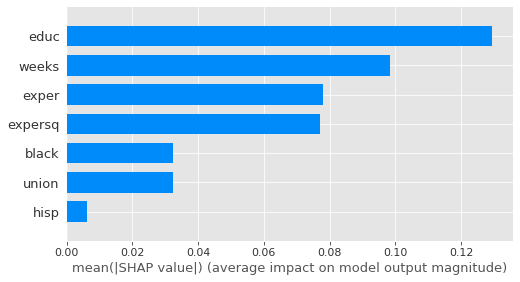

In [49]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

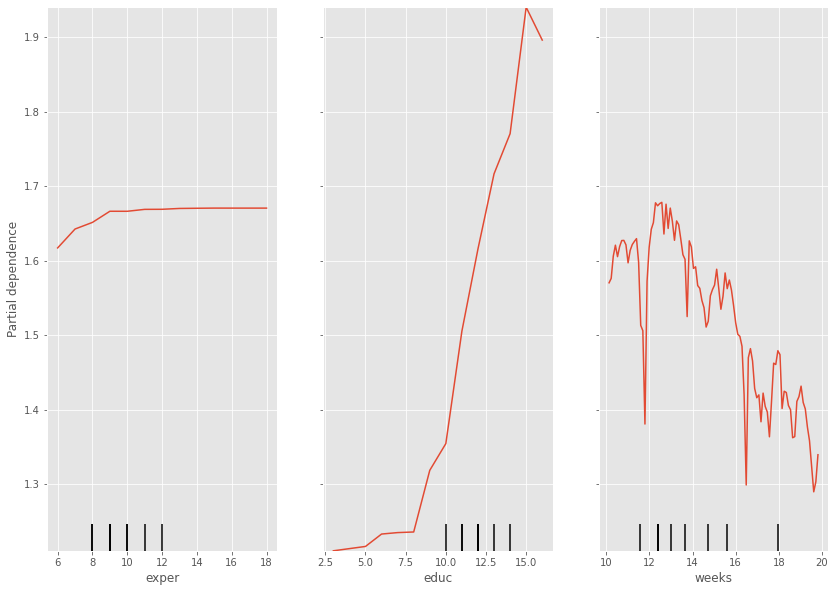

In [50]:
features = [1,3,6]
fig, ax = plt.subplots(figsize=(14, 10))
plot_partial_dependence(merf_model.trained_fe_model, X_test, features, ax=ax)

In [51]:
#shap.dependence_plot('weeks', shap_values, X_test)
# не работает для моего матплотлиба питона и нампая, нужна элегентная комбингация 3.2.2 плт 3.8 питон и 1.19 np

In [52]:
results.loc["MERF","Time"] = time.time() - start_time
y_pred = merf_model.predict(pd.DataFrame(X_test), np.ones(shape=(len(df_test),1)), pd.Series(df_test['nr']))
results.loc["MERF","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

In [53]:
gp_model = gpb.GPModel(group_data = df_train[['nr', 'year']], cov_function="exponential")

In [54]:
data_train_cat = gpb.Dataset(X_train, y_train, categorical_feature=[0,2,4])
cvbst = gpb.cv(params=params, train_set=data_train_cat, gp_model = gp_model,
               num_boost_round=1000, early_stopping_rounds=20,
               nfold=10, verbose_eval=True, show_stdv=False, seed= 42)
best_iter = np.argmin(cvbst['l2-mean'])
print("Best number of iterations: " + str(best_iter))

[1]	cv_agg's l2: 0.149725
[2]	cv_agg's l2: 0.148148
[3]	cv_agg's l2: 0.147125
[4]	cv_agg's l2: 0.146531
[5]	cv_agg's l2: 0.145977
[6]	cv_agg's l2: 0.145614
[7]	cv_agg's l2: 0.145108
[8]	cv_agg's l2: 0.144617
[9]	cv_agg's l2: 0.144064
[10]	cv_agg's l2: 0.14396
[11]	cv_agg's l2: 0.143785
[12]	cv_agg's l2: 0.143375
[13]	cv_agg's l2: 0.143295
[14]	cv_agg's l2: 0.143157
[15]	cv_agg's l2: 0.143026
[16]	cv_agg's l2: 0.142874
[17]	cv_agg's l2: 0.142767
[18]	cv_agg's l2: 0.142641
[19]	cv_agg's l2: 0.142377
[20]	cv_agg's l2: 0.142202
[21]	cv_agg's l2: 0.142316
[22]	cv_agg's l2: 0.142269
[23]	cv_agg's l2: 0.142096
[24]	cv_agg's l2: 0.142196
[25]	cv_agg's l2: 0.142173
[26]	cv_agg's l2: 0.142033
[27]	cv_agg's l2: 0.141946
[28]	cv_agg's l2: 0.141905
[29]	cv_agg's l2: 0.14189
[30]	cv_agg's l2: 0.141909
[31]	cv_agg's l2: 0.141944
[32]	cv_agg's l2: 0.141784
[33]	cv_agg's l2: 0.141657
[34]	cv_agg's l2: 0.141672
[35]	cv_agg's l2: 0.141726
[36]	cv_agg's l2: 0.141812
[37]	cv_agg's l2: 0.141803
[38]	cv_agg'

In [55]:
start_time = time.time() # measure time
bst = gpb.train(params=params, train_set=data_train_cat, num_boost_round = 65)
results.loc["Boosting_Cat","Time"] = time.time() - start_time
y_pred = bst.predict(data=X_test)
results.loc["Boosting_Cat","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

In [56]:
print(results.apply(pd.to_numeric).round(3))

               RMSE     Time
GPBoost       0.423    0.586
Linear_ME     0.371    6.049
Boosting_Ign  0.473    0.024
Boosting_Cat  0.495    0.009
MERF          0.387  548.013


In [57]:
### trying merf lgbm

In [118]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(learning_rate = .01, n_estimators = 500, class_weight = 'balanced')
merf_lgbm = MERF(lgbm, max_iterations=100)
start_time = time.time()
merf_lgbm.fit(pd.DataFrame(X_train), np.ones(shape=(len(df_train),1)), df_train['nr'], df_train['lwage'])

INFO     [merf.py:307] Training GLL is -4257.063165098069 at iteration 1.
INFO     [merf.py:307] Training GLL is -5495.277300002651 at iteration 2.
INFO     [merf.py:307] Training GLL is -5647.751106970305 at iteration 3.
INFO     [merf.py:307] Training GLL is -5668.496683480756 at iteration 4.
INFO     [merf.py:307] Training GLL is -5660.279281029762 at iteration 5.
INFO     [merf.py:307] Training GLL is -5673.895559808445 at iteration 6.
INFO     [merf.py:307] Training GLL is -5665.756150944246 at iteration 7.
INFO     [merf.py:307] Training GLL is -5673.689733811896 at iteration 8.
INFO     [merf.py:307] Training GLL is -5669.756952841152 at iteration 9.
INFO     [merf.py:307] Training GLL is -5661.910857318483 at iteration 10.
INFO     [merf.py:307] Training GLL is -5655.327701451783 at iteration 11.
INFO     [merf.py:307] Training GLL is -5659.236282927876 at iteration 12.
INFO     [merf.py:307] Training GLL is -5654.597191413659 at iteration 13.
INFO     [merf.py:307] Training GL

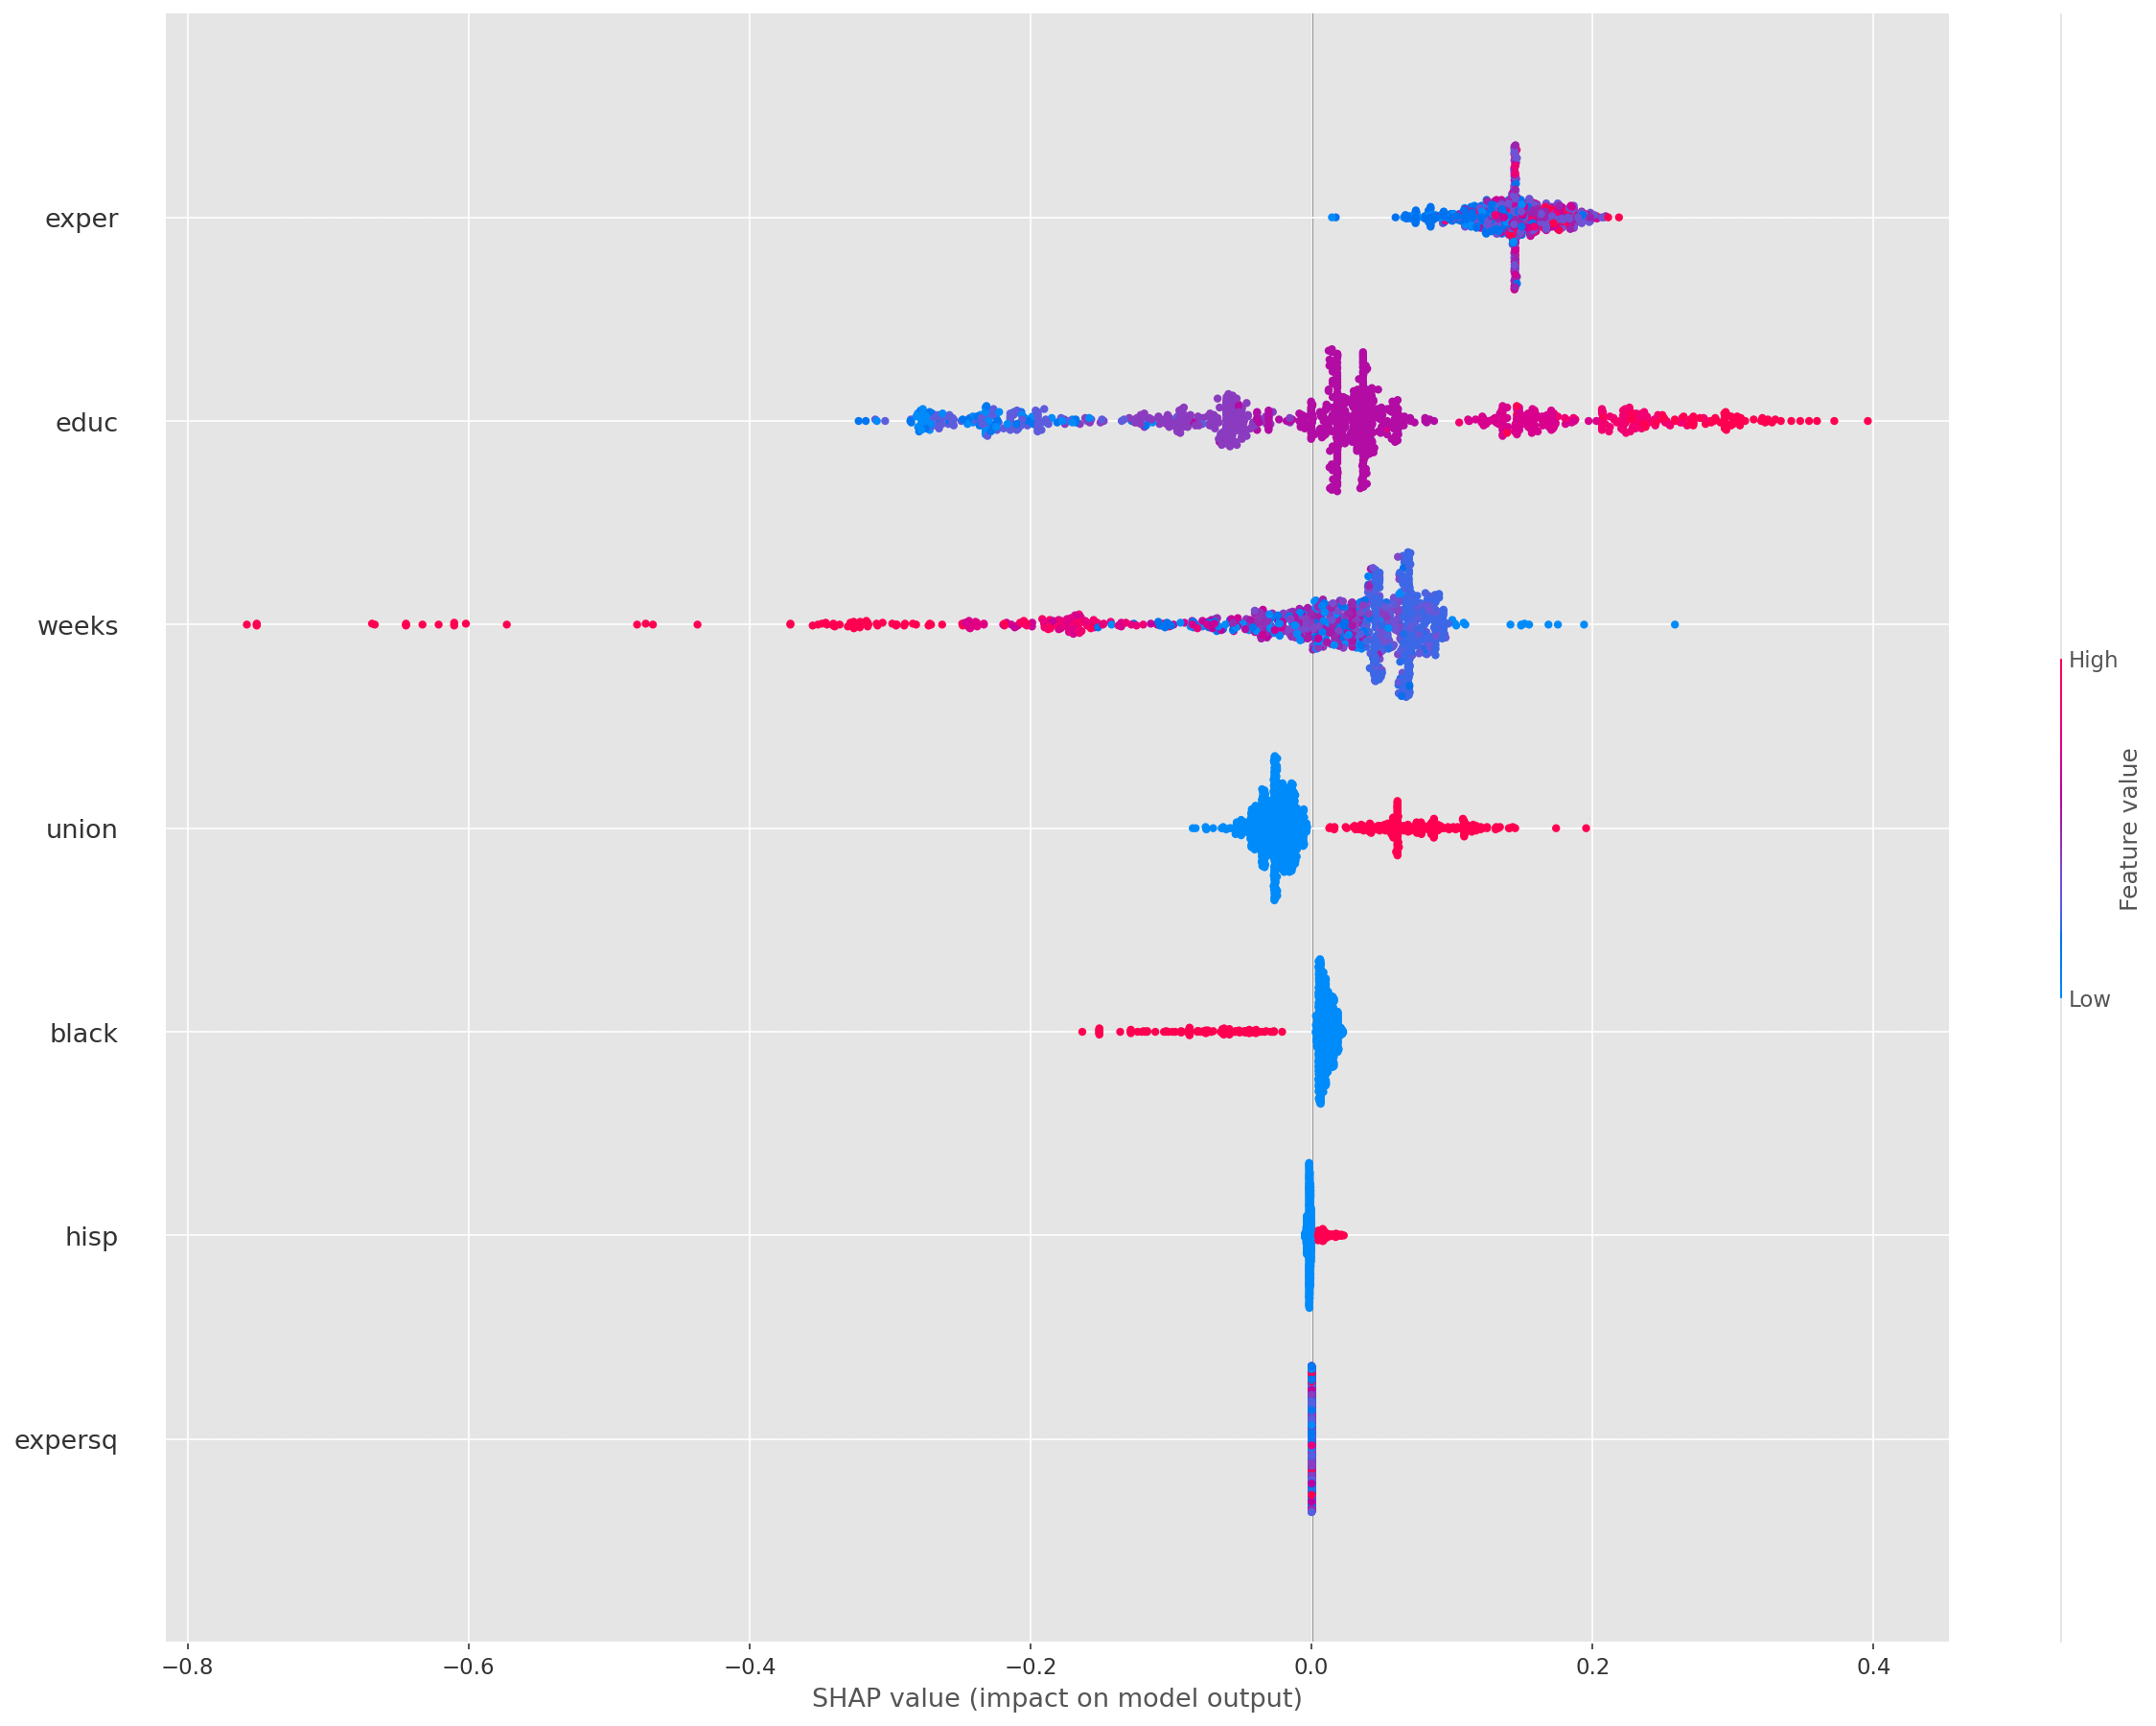

In [121]:
explainer = shap.TreeExplainer(merf_lgbm.trained_fe_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,15))

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

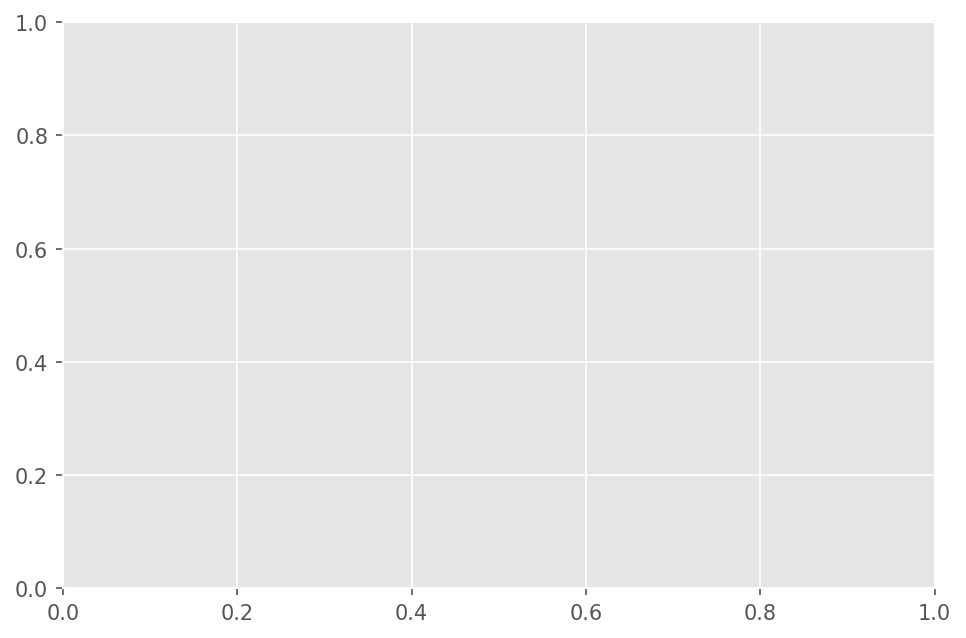

In [124]:
shap.dependence_plot('hisp', shap_values, X_test)

In [119]:
results.loc["MERF_LGBM","Time"] = time.time() - start_time
y_pred = merf_lgbm.predict(pd.DataFrame(X_test), np.ones(shape=(len(df_test),1)), pd.Series(df_test['nr']))
results.loc["MERF_LGBM","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

In [120]:
results

,RMSE,Time
GPBoost,0.42302,0.585554
Linear_ME,0.37069,6.049181
Boosting_Ign,0.472994,0.023702
Boosting_Cat,0.494811,0.009023
MERF,0.386907,548.013202
MERF_LGBM,0.377451,164.317516
Boost AR1_Linear,0.356054,NaN
Pooled Ols,0.453915,NaN
RE Model,0.455929,NaN


In [61]:
## like a panel

In [ ]:
# "fisher_scoring" более асимптотический и долгий заивисит от этты
# "gradient_descent" более робастный игнорирует колебания 

In [63]:
gp_model_ar1 = gpb.GPModel(group_data = df_train['nr'], gp_coords=df_train['year'], 
                           cluster_ids = df_train['nr'], cov_function="exponential")
gp_model_ar1.set_optim_params(params={"optimizer_cov": "gradient_descent"})
gp_model_ar1.set_prediction_data(group_data_pred = df_test['nr'], gp_coords_pred =df_test['year'], cluster_ids_pred = df_test['nr'])
data_train_ar1 = gpb.Dataset(data = np.column_stack((np.ones(len(df_train)),X_train)), label = y_train)



In [64]:
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_large,
                                             params=params,
                                             num_try_random=100,
                                             gp_model = gp_model_ar1,
                                             nfold=4,
                                             use_gp_model_for_validation=True,
                                             train_set= data_train_ar1,
                                             verbose_eval=1,
                                             num_boost_round=5000, 
                                             early_stopping_rounds=20,
                                             seed=42,
                                             metrics='rmse')

Starting random grid search with 100 trials out of 9234 parameter combinations...
Trying parameter combination 1 of 100: {'learning_rate': 0.05, 'min_data_in_leaf': 10, 'max_depth': 12, 'max_bin': 200} ...
***** New best score (0.39135855577245415) found for the following parameter combination:
{'learning_rate': 0.05, 'min_data_in_leaf': 10, 'max_depth': 12, 'max_bin': 200, 'num_boost_round': 3}
Trying parameter combination 2 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 100, 'max_depth': 18, 'max_bin': 150} ...
***** New best score (0.3832495886084642) found for the following parameter combination:
{'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 100, 'max_depth': 18, 'max_bin': 150, 'num_boost_round': 10}
Trying parameter combination 3 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 20, 'max_depth': 4, 'max_bin': 1000} ...
Trying parameter combination 4 of 100: {'learning_rate': 0.03, 'min_data_in_leaf': 10, 'max_depth': 4, 'max_bi

Trying parameter combination 58 of 100: {'learning_rate': 0.08, 'min_data_in_leaf': 50, 'max_depth': 6, 'max_bin': 100} ...
Trying parameter combination 59 of 100: {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'max_depth': 4, 'max_bin': 700} ...
Trying parameter combination 60 of 100: {'learning_rate': 0.04, 'min_data_in_leaf': 10, 'max_depth': 10, 'max_bin': 400} ...
Trying parameter combination 61 of 100: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 50, 'max_depth': 5, 'max_bin': 50} ...
Trying parameter combination 62 of 100: {'learning_rate': 0.09, 'min_data_in_leaf': 200, 'max_depth': 1, 'max_bin': 500} ...
Trying parameter combination 63 of 100: {'learning_rate': 0.04, 'min_data_in_leaf': 100, 'max_depth': 7, 'max_bin': 255} ...
Trying parameter combination 64 of 100: {'learning_rate': 0.09, 'min_data_in_leaf': 50, 'max_depth': 12, 'max_bin': 1000} ...
Trying parameter combination 65 of 100: {'learning_rate': 0.09, 'min_data_in_leaf': 50, 'max_depth': 15, 'max_b

In [65]:
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

Best number of iterations: 13
Best score: 0.378486544245001
Best parameters: {'learning_rate': 0.060000000000000005, 'min_data_in_leaf': 20, 'max_depth': 3, 'max_bin': 50}


In [66]:
params = {'objective': 'regression_l2', 'learning_rate': 0.06, 'min_data_in_leaf': 20, 'max_depth': 3, 'max_bin': 50,'verbose':1}

In [67]:
cvar = gpb.cv(params=params, train_set=data_train_ar1, gp_model = gp_model_ar1,
               num_boost_round=5000, early_stopping_rounds=40,
               nfold=10, verbose_eval=True, show_stdv=False, seed= 42)

[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 104
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 104
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 2943, number of used features: 8
[GPBoost] [Info] Total B

In [68]:
best_iter = np.argmin(cvbst['l2-mean'])
print("Best number of iterations: " + str(best_iter))

Best number of iterations: 65


In [69]:
cvar = gpb.train(params=params, train_set= data_train_ar1, gp_model = gp_model_ar1, num_boost_round=65,
               use_gp_model_for_validation=True)

[GPBoost] [Info] Total Bins 106
[GPBoost] [Info] Number of data points in the train set: 3270, number of used features: 8
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=1.587830
[GPBoost] [Info] Start training from score 1.587830


In [70]:
gp_model_ar1.summary()
cov_pars = gp_model_ar1.get_cov_pars()
phi_hat = np.exp(-1/cov_pars[3])
sigma2_hat = cov_pars[2] * (1. - phi_hat ** 2)
print("Estimated innovation variance and AR(1) coefficient of year effect:")
print([sigma2_hat ,phi_hat])

Covariance parameters 
['Error_term', 'nr', 'GP_var', 'GP_range']
[6.69127737e-02 7.37235202e-06 1.45385160e-01 8.19422456e+00]
Estimated innovation variance and AR(1) coefficient of year effect:
[0.03148615324640715, 0.8851154654600526]


In [71]:
pred = cvar.predict(data= np.column_stack((np.ones(len(df_test)),X_test)), group_data_pred = df_test['nr'], gp_coords_pred =df_test['year'], cluster_ids_pred = df_test['nr'])
y_pred = pred['fixed_effect'] + pred['random_effect_mean']  
results.loc["Boost AR1_Linear","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

In [72]:
results

,RMSE,Time
GPBoost,0.42302,0.585554
Linear_ME,0.37069,6.049181
Boosting_Ign,0.472994,0.023702
Boosting_Cat,0.494811,0.009023
MERF,0.386907,548.013202
MERF_LGBM,0.377981,18.96974
Boost AR1_Linear,0.356054,NaN


### Linear models

In [78]:
data = data.set_index(['nr','year'])

In [79]:
data

black  exper  hisp  married  educ  union     lwage  expersq  \
nr    year                                                                
13    1980      0      1     0        0    14      0  1.197540        1   
      1981      0      2     0        0    14      1  1.853060        4   
      1982      0      3     0        0    14      0  1.344462        9   
      1983      0      4     0        0    14      0  1.433213       16   
      1984      0      5     0        0    14      0  1.568125       25   
...           ...    ...   ...      ...   ...    ...       ...      ...   
12548 1983      0      8     0        1     9      0  1.591879       64   
      1984      0      9     0        1     9      1  1.212543       81   
      1985      0     10     0        1     9      0  1.765962      100   
      1986      0     11     0        1     9      1  1.745894      121   
      1987      0     12     0        1     9      1  1.466543      144   

            occupation      weeks  index  
nr    year                                
13    1980           9  15.904762      0  
      1981           9  13.809524      1  
      1982           9  17.500000      2  
      1983           9  17.619048      3  
      1984           5  18.279762      4  
...                ...        ...    ...  
12548 1983           5  12.380952   4355  
      1984           5  12.380952   4356  
      1985           5  12.380952   4357  
      1986           5  12.380952   4358  
      1987           5  20.119048   4359  

[4360 rows x 11 columns]

In [80]:
idx = pd.MultiIndex.from_product([[],[]], names=['nr', 'year'])
col = ['black', 'exper', 'hisp', 'married', 'educ', 'union', 'lwage', 'expersq', 'occupation', 'weeks', 'index']

df_train = pd.DataFrame('-', idx, col)
df_test = pd.DataFrame('-', idx, col)

In [81]:
for i in data.index.get_level_values('nr').unique():
    df_train = df_train.append(data[data.index.get_level_values('nr') == i][:6])
    df_test = df_test.append(data[data.index.get_level_values('nr') == i][6:])   

In [82]:
df_test = df_test.astype({"black": 'float64', "exper": 'float64', "hisp": 'float64', "married": 'float64', 
                          "educ": 'float64', "union": 'float64', "lwage": 'float64', "expersq": 'float64', 
                          "occupation": 'float64', "weeks": 'float64'}, errors = 'raise')
df_train = df_train.astype({"black": 'float64', "exper": 'float64', "hisp": 'float64', "married": 'float64', 
                          "educ": 'float64', "union": 'float64', "lwage": 'float64', "expersq": 'float64', 
                          "occupation": 'float64', "weeks": 'float64'}, errors = 'raise')

In [83]:
df_test.columns

Index(['black', 'exper', 'hisp', 'married', 'educ', 'union', 'lwage',
       'expersq', 'occupation', 'weeks', 'index'],
      dtype='object')

In [84]:
X_test = df_test[['black', 'exper', 'hisp', 'married', 'educ', 'union',
       'expersq', 'occupation', 'weeks']]
X_train = df_train[['black', 'exper', 'hisp', 'married', 'educ', 'union', 
       'expersq', 'occupation', 'weeks']]
y_test = df_test[['lwage']]
y_train = df_train[['lwage']]

In [85]:
mod_pooled = PooledOLS(y_train, X_train)
res_pooled = mod_pooled.fit(cov_type= 'robust')
fittedvals_pooled_OLS = res_pooled.predict(X_test)
residuals_pooled_OLS = res_pooled.resids

In [86]:
print(res_pooled) 

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.9172
Estimator:                  PooledOLS   R-squared (Between):              0.9528
No. Observations:                3270   R-squared (Within):               0.1171
Date:                Tue, Mar 22 2022   R-squared (Overall):              0.9172
Time:                        17:38:14   Log-likelihood                   -2252.2
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4013.3
Entities:                         545   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                  F(9,3261)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             4313.6
                            

In [87]:
y_pred = fittedvals_pooled_OLS['predictions'].values
y_test_test = y_test.lwage.values

In [88]:
results.loc["Pooled Ols","RMSE"] = np.sqrt(np.mean((y_test_test - y_pred) ** 2))

In [89]:
# random effects model
model_re = RandomEffects(y_train, X_train) 
re_res = model_re.fit(cov_type="robust") 

In [90]:
fittedvals_re_res =re_res.predict(X_test)
residuals_re_res = re_res.resids

In [91]:
y_pred = fittedvals_re_res['predictions'].values
results.loc["RE Model","RMSE"] = np.sqrt(np.mean((y_test_test - y_pred) ** 2))

In [93]:
print(results.apply(pd.to_numeric).round(3))

                   RMSE     Time
GPBoost           0.423    0.586
Linear_ME         0.371    6.049
Boosting_Ign      0.473    0.024
Boosting_Cat      0.495    0.009
MERF              0.387  548.013
MERF_LGBM         0.378   18.970
Boost AR1_Linear  0.356      NaN
Pooled Ols        0.454      NaN
RE Model          0.456      NaN
